### Import of libraries and defining paths to files

In [23]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
BASE_PATH = r"C:\Users\micha\OneDrive\Pulpit\Project\Bitcoin_pred\data"

PATH_TO_ORIGINAL_DATA = f"{BASE_PATH}\\Bitcoin.csv"

PATH_TO_CLEANED_DATA = f"{BASE_PATH}/cleaned_data.csv"

PATH_TO_TARGET_DATA = f"{BASE_PATH}/target_data.csv"

PATH_TO_TIME_FEATURES = f"{BASE_PATH}/time_features.csv"

PATH_TO_SPECIFIC_FEATURES = f"{BASE_PATH}/specific_features.csv"

PATH_TO_TRAINING_DATA = f"{BASE_PATH}/training_data.csv"
PATH_TO_VALIDATION_DATA = f"{BASE_PATH}/validation_data.csv"
PATH_TO_TESTING_DATA = f"{BASE_PATH}/testing_data.csv"

### Calendar Feature Engineering

First, independent variables related to time, such as quarters, days of the week, etc., will be created.

In [3]:
cleaned_df = pd.read_csv(PATH_TO_CLEANED_DATA)
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
cleaned_df.set_index('date', inplace=True)

In [4]:
cleaned_df

,price,total_volume,market_cap
date,,,
2015-01-04,260.936000,2.055001e+08,3.571640e+09
2015-01-05,273.220000,1.550381e+08,3.740880e+09
2015-01-06,285.373800,9.700290e+07,3.908408e+09
2015-01-07,295.872500,1.106742e+08,4.053239e+09
2015-01-08,284.452500,8.657054e+07,3.897824e+09
...,...,...,...
2024-01-10,46105.946078,3.988792e+10,9.021669e+11
2024-01-11,46632.313148,5.203006e+10,9.152593e+11
2024-01-12,46314.355542,4.919813e+10,9.098464e+11


In [5]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3297 entries, 2015-01-04 00:00:00 to 2024-01-14 00:00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         3297 non-null   float64
 1   total_volume  3297 non-null   float64
 2   market_cap    3297 non-null   float64
dtypes: float64(3)
memory usage: 103.0 KB


In [6]:
attributes = ['year', 'month', 'day', 'dayofweek', 'quarter', 'dayofyear', 'weekofyear']
cleaned_df = cleaned_df.assign(**{attr: getattr(cleaned_df.index, attr) for attr in attributes})
cleaned_df[attributes].to_csv(PATH_TO_TIME_FEATURES)

In [7]:
cleaned_df

,price,total_volume,market_cap,year,month,day,dayofweek,quarter,dayofyear,weekofyear
date,,,,,,,,,,
2015-01-04,260.936000,2.055001e+08,3.571640e+09,2015,1,4,6,1,4,1
2015-01-05,273.220000,1.550381e+08,3.740880e+09,2015,1,5,0,1,5,2
2015-01-06,285.373800,9.700290e+07,3.908408e+09,2015,1,6,1,1,6,2
2015-01-07,295.872500,1.106742e+08,4.053239e+09,2015,1,7,2,1,7,2
2015-01-08,284.452500,8.657054e+07,3.897824e+09,2015,1,8,3,1,8,2
...,...,...,...,...,...,...,...,...,...,...
2024-01-10,46105.946078,3.988792e+10,9.021669e+11,2024,1,10,2,1,10,2
2024-01-11,46632.313148,5.203006e+10,9.152593e+11,2024,1,11,3,1,11,2
2024-01-12,46314.355542,4.919813e+10,9.098464e+11,2024,1,12,4,1,12,2


### Time Series Feature Engineering

The next step will be to create new features based on data from the time series, supplemented with data analysis.

In [9]:
cleaned_df = pd.read_csv(PATH_TO_CLEANED_DATA)
target_df = pd.read_csv(PATH_TO_TARGET_DATA)

cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
target_df['date'] = pd.to_datetime(target_df['date'])

features_df = pd.merge(target_df, cleaned_df, on='date', how='inner')

In [11]:
features_df.set_index('date', inplace=True)
features_df

,price_target,price,total_volume,market_cap
date,,,,
2015-01-04,313.992000,260.936000,2.055001e+08,3.571640e+09
2015-01-05,314.446000,273.220000,1.550381e+08,3.740880e+09
2015-01-06,286.572000,285.373800,9.700290e+07,3.908408e+09
2015-01-07,260.936000,295.872500,1.106742e+08,4.053239e+09
2015-01-08,273.220000,284.452500,8.657054e+07,3.897824e+09
...,...,...,...,...
2024-01-10,43956.120717,46105.946078,3.988792e+10,9.021669e+11
2024-01-11,43883.743879,46632.313148,5.203006e+10,9.152593e+11
2024-01-12,46936.185561,46314.355542,4.919813e+10,9.098464e+11


In [12]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3297 entries, 2015-01-04 00:00:00 to 2024-01-14 00:00:00
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price_target  3297 non-null   float64
 1   price         3297 non-null   float64
 2   total_volume  3297 non-null   float64
 3   market_cap    3297 non-null   float64
dtypes: float64(4)
memory usage: 128.8 KB


In [14]:
result = adfuller(features_df['price_target'])

print('ADF Test Statistic:', result[0])
print('p-value:', result[1])
print('Used Lags:', result[2])
print('Number of Observations Used for ADF Regression and Critical Values Calculation:', result[3])

print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] > 0.05:
    print("The series is non-stationary and has a unit root, indicating it is time-dependent.")
else:
    print("The series is stationary and does not have a unit root, indicating it is not time-dependent.")

ADF Test Statistic: -1.1619897250714732
p-value: 0.6897294351102677
Used Lags: 29
Number of Observations Used for ADF Regression and Critical Values Calculation: 3267
Critical Values:
	1%: -3.4323531972725316
	5%: -2.862425093278735
	10%: -2.567241153905792
The series is non-stationary and has a unit root, indicating it is time-dependent.


Considering the above values, the test statistic does not exceed any of the critical values, which further confirms that the null hypothesis of non-stationarity cannot be rejected. This means that the time series being analyzed is time-dependent and may require differencing or other transformations to achieve stationarity before further time series modeling analysis can be conducted.

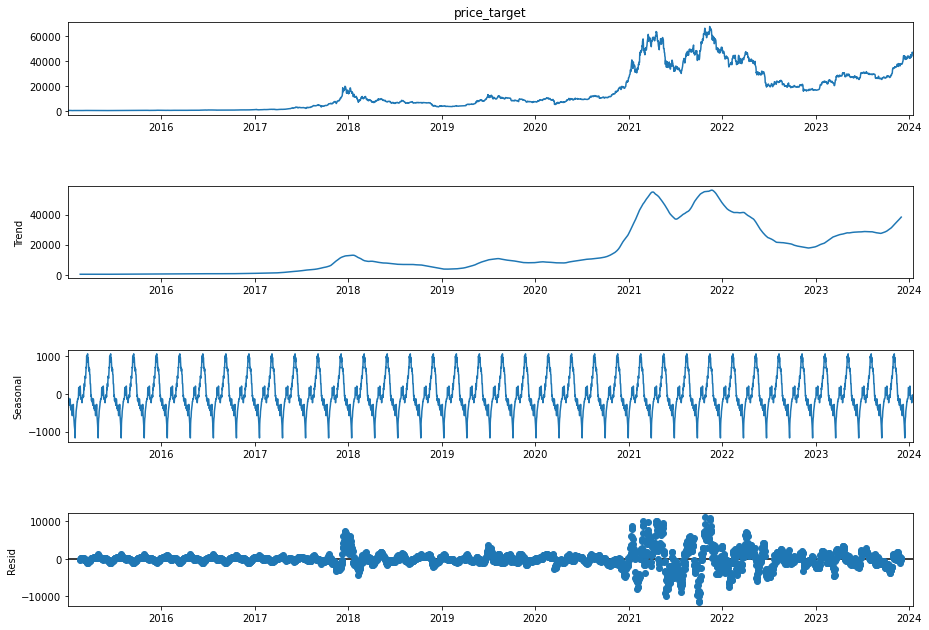

In [18]:
result = seasonal_decompose(features_df['price_target'], model='additive', period=90)
fig = result.plot()
fig.set_size_inches(15, 10)
plt.show()

Analyzing the above charts, it should be noted that the time series exhibits strong seasonality and a disturbance in the trend during the period 2021 - 2023. The anomaly is not explained by the available data, as shown by the residual plot, and is likely due to the COVID-19 pandemic.

In [19]:
features_df['price_trend'] = result.trend
features_df['price_seasonal'] = result.seasonal
features_df['price_resid'] = result.resid

In [20]:
result = adfuller(features_df['total_volume'])

print('ADF Test Statistic:', result[0])
print('p-value:', result[1])
print('Used Lags:', result[2])
print('Number of Observations Used for ADF Regression and Critical Values Calculation:', result[3])

print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] > 0.05:
    print("The series is non-stationary and has a unit root, indicating it is time-dependent.")
else:
    print("The series is stationary and does not have a unit root, indicating it is not time-dependent.")

ADF Test Statistic: -2.324417535972173
p-value: 0.16421371019811215
Used Lags: 27
Number of Observations Used for ADF Regression and Critical Values Calculation: 3269
Critical Values:
	1%: -3.4323519707362373
	5%: -2.8624245515277273
	10%: -2.5672408654891967
The series is non-stationary and has a unit root, indicating it is time-dependent.


Considering the above values, the test statistic does not exceed any of the critical values, which further confirms that the null hypothesis of non-stationarity cannot be rejected. This means that the time series being analyzed is time-dependent and may require differencing or other transformations to achieve stationarity before further time series modeling analysis can be conducted.

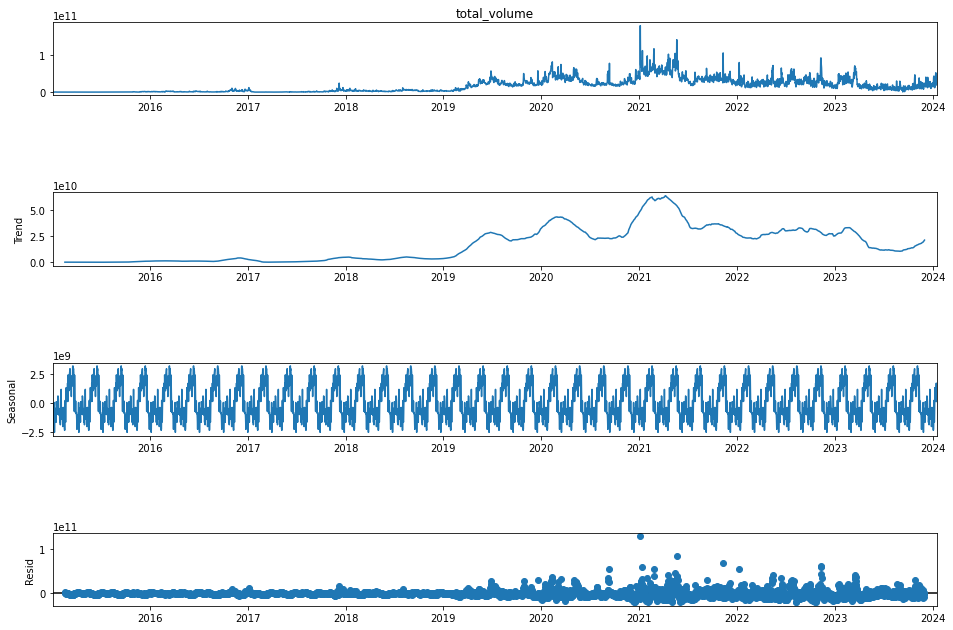

In [21]:
result = seasonal_decompose(features_df['total_volume'], model='additive', period=90)
fig = result.plot()
fig.set_size_inches(15, 10)
plt.show()

In [22]:
features_df['total_volume_trend'] = result.trend
features_df['total_volume_seasonal'] = result.seasonal
features_df['total_volume_resid'] = result.resid

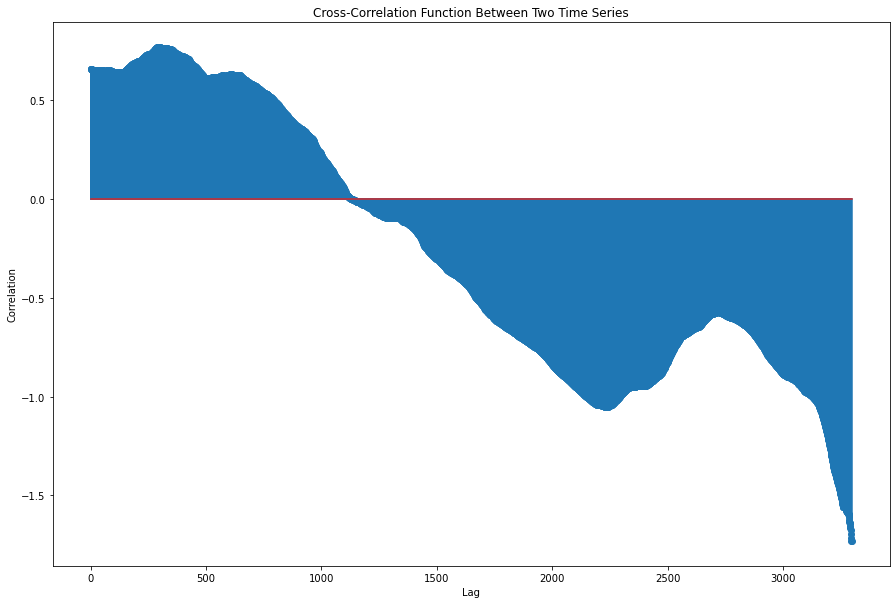

In [24]:
correlations = ccf(features_df['price_target'], features_df['total_volume'], unbiased=True)
plt.figure(figsize=(15, 10))
plt.stem(range(len(correlations)), correlations, use_line_collection=False)
plt.title('Cross-Correlation Function Between Two Time Series')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

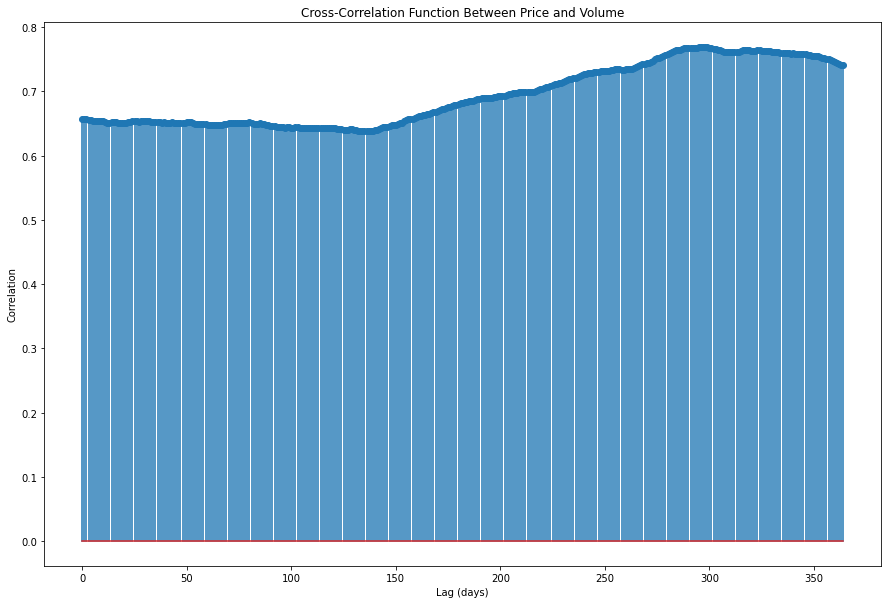

In [25]:
max_lags = 365
correlations = ccf(features_df['price_target'], features_df['total_volume'], unbiased=True)[:max_lags]
plt.figure(figsize=(15, 10))
plt.stem(range(len(correlations)), correlations, use_line_collection=False)
plt.title('Cross-Correlation Function Between Price and Volume')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()

In [26]:
max_corr_lag = np.argmax(correlations)
features_df['lagged_total_volume'] = features_df['total_volume'].shift(max_corr_lag)
print("Lag for highest correlation:", max_corr_lag)

Lag for highest correlation: 298


The analysis of the correlations indicates that an additional feature should be created that includes a lag of the "total_volume" values.

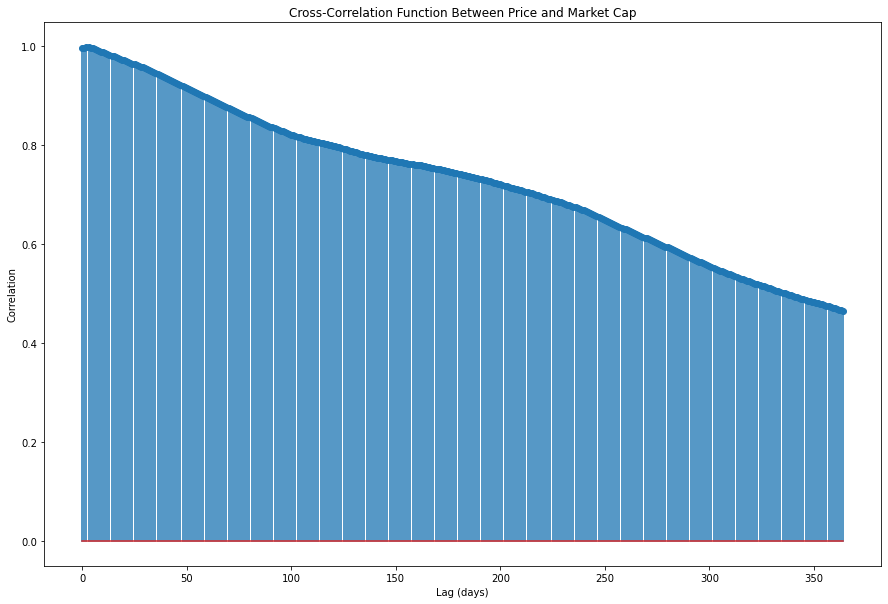

In [27]:
max_lags = 365
correlations = ccf(features_df['price_target'], features_df['market_cap'], unbiased=True)[:max_lags]
plt.figure(figsize=(15, 10))
plt.stem(range(len(correlations)), correlations, use_line_collection=False)
plt.title('Cross-Correlation Function Between Price and Market Cap')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.show()

In [28]:
def add_rolling_features(features_df, column, periods):
    for period, days in periods.items():
        window = features_df[column].rolling(window=days, min_periods=1)
        features_df[f'{column}_moving_average_{period}'] = window.mean()
        features_df[f'{column}_max_{period}'] = window.max()
        features_df[f'{column}_min_{period}'] = window.min()
        features_df[f'{column}_std_{period}'] = window.std()
        features_df[f'{column}_median_{period}'] = window.median()
        features_df[f'{column}_skew_{period}'] = window.skew()
        features_df[f'{column}_kurtosis_{period}'] = window.kurt()
        features_df[f'{column}_quartile_change_{period}'] = window.quantile(0.75) - window.quantile(0.25)
        features_df[f'{column}_sum_{period}'] = window.sum()

periods = {
    'week': 7,
    'month': 30,
    'quarter': 90,
    'semester': 182,
    'year': 365
}
columns_to_analyze = ['price_target', 'total_volume', 'market_cap']

for col in columns_to_analyze:
    add_rolling_features(features_df, col, periods)

In [29]:
def calculate_rsi(data, window_length=14):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window_length, min_periods=1).mean()
    roll_down = down.abs().rolling(window=window_length, min_periods=1).mean()
    
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def calculate_macd(data, span_fast=12, span_slow=26, span_signal=9):
    fast_ema = data.ewm(span=span_fast, adjust=False).mean()
    slow_ema = data.ewm(span=span_slow, adjust=False).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=span_signal, adjust=False).mean()
    return macd, signal

def calculate_bollinger_bands(data, window=20):
    ma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = ma + (std * 2)
    lower_band = ma - (std * 2)
    return upper_band, lower_band

def add_technical_indicators(features_df, columns):
    for col in columns:
        features_df[f'{col}_RSI'] = calculate_rsi(features_df[col])
        macd, signal = calculate_macd(features_df[col])
        features_df[f'{col}_MACD'] = macd
        features_df[f'{col}_MACD_Signal'] = signal
        upper_band, lower_band = calculate_bollinger_bands(features_df[col])
        features_df[f'{col}_Bollinger_Upper'] = upper_band
        features_df[f'{col}_Bollinger_Lower'] = lower_band

columns_to_analyze = ['price_target', 'total_volume', 'market_cap']
add_technical_indicators(features_df, columns_to_analyze)

In [30]:
features_df

,price_target,price,total_volume,market_cap,price_trend,price_seasonal,price_resid,total_volume_trend,total_volume_seasonal,total_volume_resid,...,total_volume_RSI,total_volume_MACD,total_volume_MACD_Signal,total_volume_Bollinger_Upper,total_volume_Bollinger_Lower,market_cap_RSI,market_cap_MACD,market_cap_MACD_Signal,market_cap_Bollinger_Upper,market_cap_Bollinger_Lower
date,,,,,,,,,,,,,,,,,,,,,
2015-01-04,313.992000,260.936000,2.055001e+08,3.571640e+09,NaN,-114.535712,NaN,NaN,-2.265135e+09,NaN,...,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN
2015-01-05,314.446000,273.220000,1.550381e+08,3.740880e+09,NaN,-204.761874,NaN,NaN,-1.045182e+09,NaN,...,0.000000,-4.025461e+06,-8.050921e+05,NaN,NaN,100.000000,1.350068e+07,2.700136e+06,NaN,NaN
2015-01-06,286.572000,285.373800,9.700290e+07,3.908408e+09,NaN,-216.954659,NaN,NaN,-1.534552e+09,NaN,...,0.000000,-1.176303e+07,-2.996679e+06,NaN,NaN,100.000000,3.728832e+07,9.617772e+06,NaN,NaN
2015-01-07,260.936000,295.872500,1.106742e+08,4.053239e+09,NaN,-217.313601,NaN,NaN,-1.653080e+09,NaN,...,11.190550,-1.660058e+07,-5.717460e+06,NaN,NaN,100.000000,6.705385e+07,2.110499e+07,NaN,NaN
2015-01-08,273.220000,284.452500,8.657054e+07,3.897824e+09,NaN,-305.351054,NaN,NaN,-1.137536e+09,NaN,...,9.346499,-2.212431e+07,-8.998830e+06,NaN,NaN,75.602625,7.721254e+07,3.232650e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-10,43956.120717,46105.946078,3.988792e+10,9.021669e+11,NaN,-236.304496,NaN,NaN,1.286794e+09,NaN,...,58.260862,2.721649e+09,1.338238e+09,4.358349e+10,3.405973e+09,63.588921,1.896935e+10,1.538745e+10,9.046099e+11,8.075741e+11
2024-01-11,43883.743879,46632.313148,5.203006e+10,9.152593e+11,NaN,-125.437179,NaN,NaN,3.098906e+08,NaN,...,61.345493,4.472061e+09,1.965003e+09,4.876756e+10,1.230042e+09,63.066093,2.124470e+10,1.655890e+10,9.142188e+11,8.036599e+11
2024-01-12,46936.185561,46314.355542,4.919813e+10,9.098464e+11,NaN,-40.477166,NaN,NaN,1.211987e+08,NaN,...,61.382390,5.566594e+09,2.685321e+09,5.241930e+10,4.147187e+08,65.049323,2.235347e+10,1.771781e+10,9.211350e+11,8.015461e+11


In [31]:
features_df.iloc[:, 4:].to_csv(PATH_TO_SPECIFIC_FEATURES)